In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm

import pandas as pd

import time
t1 = time.time()

import os
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile

from datetime import datetime

from matplotlib import cm
from pylab import rcParams
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
import scipy.interpolate as spi
from scipy.interpolate import splrep, splev
import scipy.cluster.hierarchy as spc

import scipy.io
import math

from sklearn import metrics

import itertools

In [2]:
file_dir = os.path.join('/Users/digisha/Downloads/Fatigue_project/data')
file_name = os.path.join(file_dir, 'VAS_data_for_Digisha_073119.xlsx')
df = pd.read_excel(file_name, sheetname = "Sheet1")

#df = pd.read_excel(file_with_data, sheetname=sheet_with_data)

df.head()

/Applications/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,guid,subject_id,question_id,answer,other,is_checked,timestamp
0,473edf673e4c41e6bd329e01fcd0926b,1,1600,4,NaN,NaN,05-31-2018 08:45:51
1,11f45a3f6a5a456aa6d7e238fcf5801d,1,1601,0,NaN,NaN,05-31-2018 08:46:01
2,edb12413c16c457581358b8174855950,1,1602,0,NaN,NaN,05-31-2018 08:46:09
3,6fa93d8d070c4e3a89288038e5e99579,1,1603,0,NaN,NaN,05-31-2018 08:46:17
4,efec8a7b09a5499a85a4008bc606ef7f,1,1600,6,NaN,NaN,05-31-2018 16:16:58


In [3]:
#changing datatypes, time stamp in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.drop(['guid', 'other', 'is_checked'], axis=1)

In [4]:
#only depression fatigue questionnare considererd
mask = (df['subject_id'] != 99998)
df = df.loc[mask].reset_index(drop=True)
mask = (df['subject_id'] != 19)
df = df.loc[mask].reset_index(drop=True)
#df['time'] = [t.time() for t in df['timestamp']]#.progress_apply(lambda x: x.timestamp)
#df['time'] = df['time'].apply(lambda x: x.strftime('%H:%M:%S'))
df.head()

,subject_id,question_id,answer,timestamp
0,1,1600,4,2018-05-31 08:45:51
1,1,1601,0,2018-05-31 08:46:01
2,1,1602,0,2018-05-31 08:46:09
3,1,1603,0,2018-05-31 08:46:17
4,1,1600,6,2018-05-31 16:16:58


In [5]:
datetime_object = datetime.strptime('00:00:00', '%H:%M:%S')
df['answer']=df.answer.astype('int64')
df['hour'] = 0.00

with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
        df['hour'][i] = (df['timestamp'][i] - datetime_object).seconds/(60*60)
        df['hour'][i] = df['hour'][i].round(2)
        pbar.update(1)
    
df.head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,subject_id,question_id,answer,timestamp,hour
0,1,1600,4,2018-05-31 08:45:51,8.76
1,1,1601,0,2018-05-31 08:46:01,8.77
2,1,1602,0,2018-05-31 08:46:09,8.77
3,1,1603,0,2018-05-31 08:46:17,8.77
4,1,1600,6,2018-05-31 16:16:58,16.28


In [6]:
# date column added to know if the questionnaire is a part of the same day or the next
df['date'] = [d.date() for d in df['timestamp']]

In [7]:
k = df.subject_id.unique()
print(np.sort(k))
len(k)

[ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 20 22 23 24 25 26 27
 29 30 31 34 35 36 37 39 40 41 43 45 47 48 50 52 53]


41

In [8]:
df['time'] = 0
df['day'] = 0
k = 0
df['time'] = df['time'].astype('float')

patient = df.subject_id.unique()

qid = [1600,1601,1602,1603]

with tqdm(total= (len(patient)*len(qid))) as pbar:
    for q in qid:
        for pat in patient:
            count = 0
            for i in range(0,len(df)):
                if q == df['question_id'][i]:
                    if pat == df['subject_id'][i]:
                        if count == 0:
                            df['time'][i] = 0 + (df['hour'][i]/24)
                            df['day'][i] = 0
                            count+= 1
                            k = i
                        else:
                            df['time'][i] = (df['timestamp'][i] - df['timestamp'][k]).days + (df['hour'][i]/24)
                            df['day'][i] = (df['timestamp'][i] - df['timestamp'][k]).days
            pbar.update(1)

df['time'] = df['time'].round(3)
df = df[df.day < 14]
#df = df.sort_values(['subject_id', 'time'], ascending=[True, True])
df.head(7)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to 

,subject_id,question_id,answer,timestamp,hour,date,time,day
0,1,1600,4,2018-05-31 08:45:51,8.76,2018-05-31,0.365,0
1,1,1601,0,2018-05-31 08:46:01,8.77,2018-05-31,0.365,0
2,1,1602,0,2018-05-31 08:46:09,8.77,2018-05-31,0.365,0
3,1,1603,0,2018-05-31 08:46:17,8.77,2018-05-31,0.365,0
4,1,1600,6,2018-05-31 16:16:58,16.28,2018-05-31,0.678,0
5,1,1601,0,2018-05-31 16:17:04,16.28,2018-05-31,0.678,0
6,1,1602,1,2018-05-31 16:17:20,16.29,2018-05-31,0.679,0


In [9]:
mask = (df['question_id'] == 1600)
df_00 = df.loc[mask].reset_index(drop=True)

mask = (df['question_id'] == 1601)
df_01 = df.loc[mask].reset_index(drop=True)

mask = (df['question_id'] == 1602)
df_02 = df.loc[mask].reset_index(drop=True)

mask = (df['question_id'] == 1603)
df_03 = df.loc[mask].reset_index(drop=True)

df_00 = df_00.drop(['timestamp', 'hour', 'date', "question_id"], axis=1).sort_values(by=['time'])
df_01 = df_01.drop(['timestamp', 'hour', 'date', "question_id"], axis=1).sort_values(by=['time'])
df_02 = df_02.drop(['timestamp', 'hour', 'date', "question_id"], axis=1).sort_values(by=['time'])
df_03 = df_03.drop(['timestamp', 'hour', 'date', "question_id"], axis=1).sort_values(by=['time'])

In [10]:
# Utility Functions

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            #pass
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    plt.show()

# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (24, 12)

In [11]:
UniqueNames = df.subject_id.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

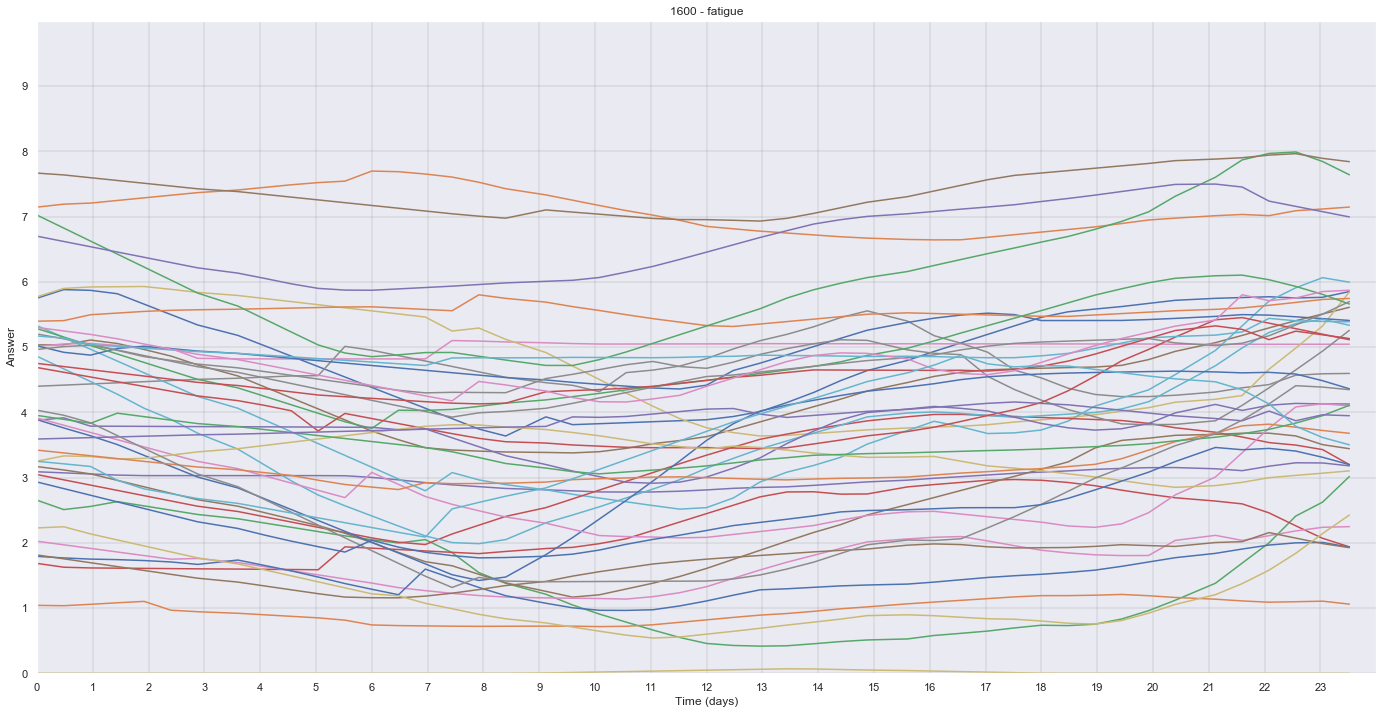

In [12]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_00[:][df_00.subject_id == key]

#Dict = {}
traj_lst1 = []
yt1 = []

with tqdm(total=len(UniqueNames)) as pbar:
    for key in UniqueNames:
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/48)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        subj = [key] * len(xnew)
        X = np.array(list(zip(subj, xnew, ynew)))
        traj_lst1.append(X)
        yt1.append(ynew)
        pbar.update(1)
    #print(traj_lst1)
    
traj_lst1 = list(itertools.chain(*traj_lst1))

dataset = pd.DataFrame(traj_lst1, columns=['subject_id','time', 'answer'])

dataset["time"] = round(dataset["time"] % 1,2)

dataset = dataset.groupby(['subject_id','time'])['answer'].sum().reset_index()
dataset["answer"] = dataset["answer"]/14
dataset.head(5)

for key in DataFrameDict.keys():
    DataFrameDict[key] = dataset[:][dataset.subject_id == key]

#Dict = {}
traj_lst01 = []
yt01 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values*24
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        X = np.array(list(zip(x, y)))
        traj_lst01.append(X)
        yt01.append(y)
        pbar.update(1)

for traj in traj_lst01:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 24)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 24, 1))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1600 - fatigue')
plt.grid(color='grey', linestyle='-', linewidth=0.25)

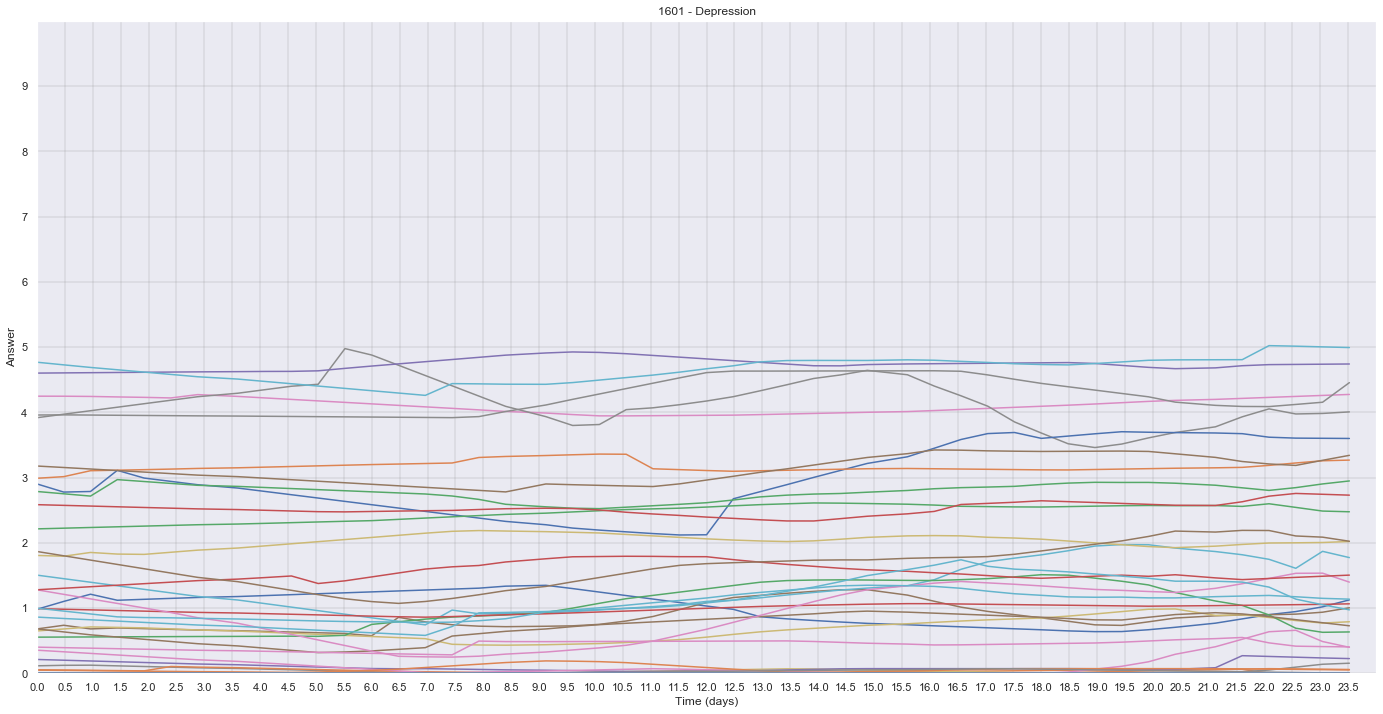

In [13]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_01[:][df_01.subject_id == key]

#Dict = {}
traj_lst2 = []
yt2 = []

with tqdm(total=len(UniqueNames)) as pbar:
    for key in UniqueNames:
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/48)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        subj = [key] * len(xnew)
        X = np.array(list(zip(subj, xnew, ynew)))
        traj_lst2.append(X)
        yt2.append(ynew)
        pbar.update(1)
    #print(traj_lst2)
    
traj_lst2 = list(itertools.chain(*traj_lst2))

dataset = pd.DataFrame(traj_lst2, columns=['subject_id','time', 'answer'])

dataset["time"] = round(dataset["time"] % 1,2)

dataset = dataset.groupby(['subject_id','time'])['answer'].sum().reset_index()
dataset["answer"] = dataset["answer"]/14
dataset.head(5)

for key in DataFrameDict.keys():
    DataFrameDict[key] = dataset[:][dataset.subject_id == key]

#Dict = {}
traj_lst02 = []
yt02 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values*24
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        X = np.array(list(zip(x, y)))
        traj_lst02.append(X)
        yt02.append(y)
        pbar.update(1)

for traj in traj_lst02:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 24)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 24, 0.5))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1601 - Depression')
plt.grid(color='grey', linestyle='-', linewidth=0.25)

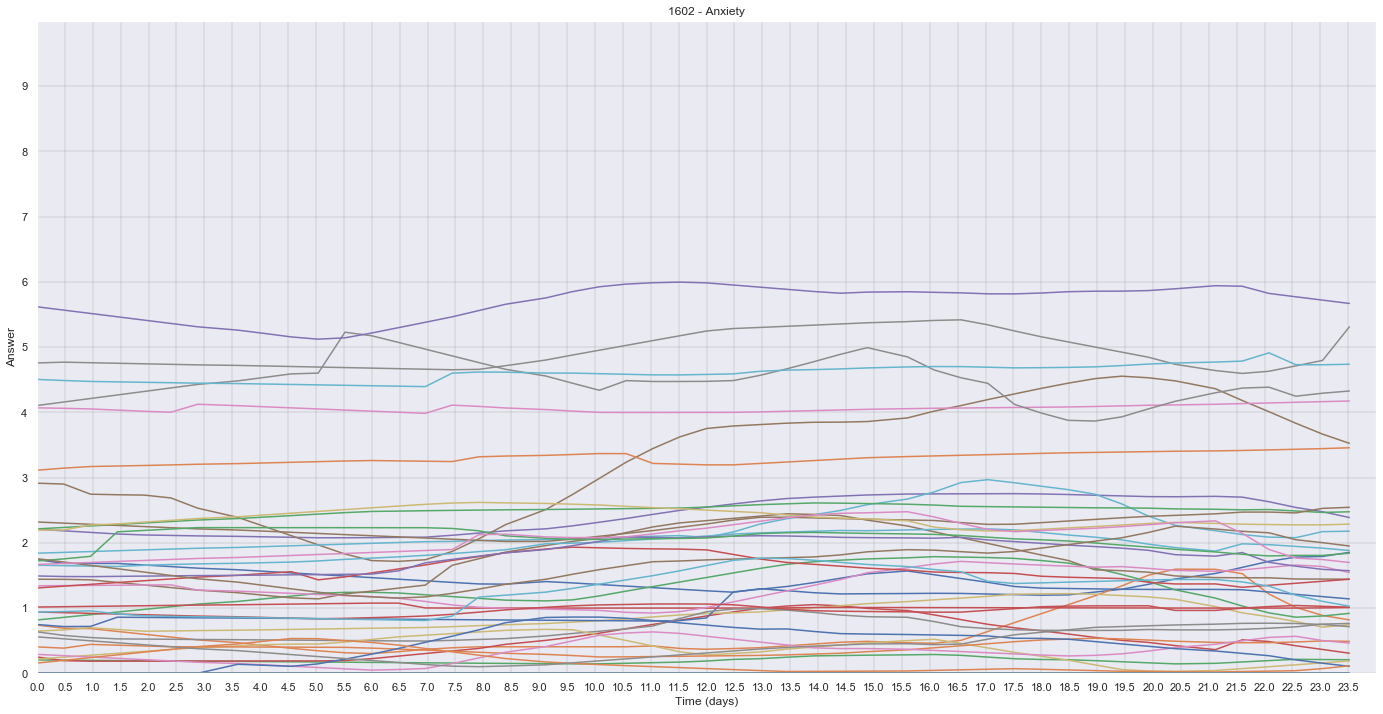

In [14]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_02[:][df_02.subject_id == key]

#Dict = {}
traj_lst3 = []
yt3 = []

with tqdm(total=len(UniqueNames)) as pbar:
    for key in UniqueNames:
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/48)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        subj = [key] * len(xnew)
        X = np.array(list(zip(subj, xnew, ynew)))
        traj_lst3.append(X)
        yt3.append(ynew)
        pbar.update(1)
    #print(traj_lst3)
    
traj_lst3 = list(itertools.chain(*traj_lst3))

dataset = pd.DataFrame(traj_lst3, columns=['subject_id','time', 'answer'])

dataset["time"] = round(dataset["time"] % 1,2)

dataset = dataset.groupby(['subject_id','time'])['answer'].sum().reset_index()
dataset["answer"] = dataset["answer"]/14
dataset.head(5)

for key in DataFrameDict.keys():
    DataFrameDict[key] = dataset[:][dataset.subject_id == key]

#Dict = {}
traj_lst03 = []
yt03 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values*24
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        X = np.array(list(zip(x, y)))
        traj_lst03.append(X)
        yt03.append(y)
        pbar.update(1)

for traj in traj_lst03:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 24)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 24, 0.5))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1602 - Anxiety')
plt.grid(color='grey', linestyle='-', linewidth=0.25)


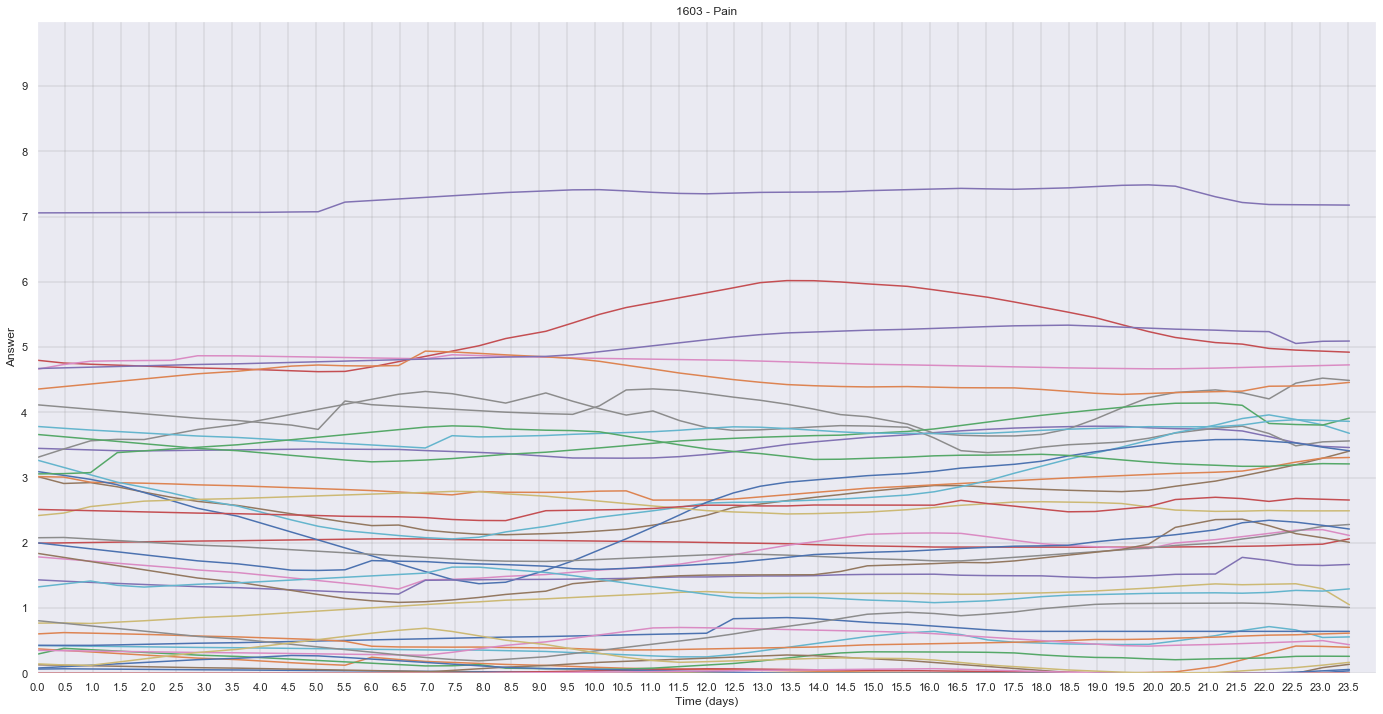

In [15]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = df_03[:][df_03.subject_id == key]

#Dict = {}
traj_lst4 = []
yt4 = []

with tqdm(total=len(UniqueNames)) as pbar:
    for key in UniqueNames:
        x = DataFrameDict[key]['time'].values
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        xnew = np.arange(0,13,1/48)
        intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
        ynew = intfunc(xnew)
        xnew = xnew.round(3)
        ynew = ynew.round(3)
        subj = [key] * len(xnew)
        X = np.array(list(zip(subj, xnew, ynew)))
        traj_lst4.append(X)
        yt4.append(ynew)
        pbar.update(1)
    #print(traj_lst4)
    
traj_lst4 = list(itertools.chain(*traj_lst4))

dataset = pd.DataFrame(traj_lst4, columns=['subject_id','time', 'answer'])

dataset["time"] = round(dataset["time"] % 1,2)

dataset = dataset.groupby(['subject_id','time'])['answer'].sum().reset_index()
dataset["answer"] = dataset["answer"]/14
dataset.head(5)

for key in DataFrameDict.keys():
    DataFrameDict[key] = dataset[:][dataset.subject_id == key]

#Dict = {}
traj_lst04 = []
yt04 = []

with tqdm(total= len(UniqueNames)) as pbar:
    for key in UniqueNames:
        #print(DataFrameDict[key])
        x = DataFrameDict[key]['time'].values*24
        y = DataFrameDict[key]['answer'].values
        np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
        X = np.array(list(zip(x, y)))
        traj_lst04.append(X)
        yt04.append(y)
        pbar.update(1)

for traj in traj_lst04:
    plt.plot(traj[:, 0], traj[:, 1])
    
plt.ylim(0, 10)
plt.xlim(0, 24)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 24, 0.5))
plt.xlabel('Time (days)')
plt.ylabel('Answer')
plt.title('1603 - Pain')
plt.grid(color='grey', linestyle='-', linewidth=0.25)


In [16]:
X = np.array(list(zip(yt01, yt02, yt03, yt04)))

In [17]:
def corr_dist(T1, T2):
    # pearson Correlation coefficient using matrix correlation formula
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        correlation = numerator / denominator
    #converting correlation to correlation matrix format to calculate pdist
    corr_matrix = np.zeros((2, 2))
    corr_matrix[0,0] = correlation
    corr_matrix[1,1] = correlation
    #converting correlation to distance        
    pdist = spc.distance.pdist(corr_matrix)
    #to bypass NaN data
    if math.isnan(pdist):
            pdist = 0
    if math.isnan(correlation):
            correlation = 0.00
    return correlation,pdist

In [18]:
traj_count = len(UniqueNames)
D = np.zeros((traj_count, traj_count))
corr_matrix = np.zeros((traj_count, traj_count))

cluster = []

# This may take a while
for i in range(0, traj_count):
    for j in range(i + 1, traj_count):
        #print(i,j)yt[u]
        corr, distance = corr_dist(yt1[i], yt1[j])
        #print (corr.round(3), distance)
        D[i, j] = distance
        D[j, i] = distance
        corr_matrix[i, j] = corr
        corr_matrix[j, i] = corr

linkage = spc.linkage(D, method='complete')       
clust = spc.fcluster(linkage, t= 5, criterion= "maxclust")

clusters_24hr = np.array(list(zip(UniqueNames, clust)))
#corr_matrix

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


In [19]:
print(clusters_24hr)

[[ 1  3]
 [ 3  2]
 [ 2  2]
 [ 5  2]
 [ 4  3]
 [ 6  4]
 [ 8  1]
 [ 9  2]
 [11  2]
 [12  5]
 [13  4]
 [ 7  2]
 [14  3]
 [15  2]
 [16  5]
 [17  5]
 [18  5]
 [20  2]
 [22  2]
 [23  3]
 [24  3]
 [25  1]
 [26  5]
 [27  5]
 [29  2]
 [30  5]
 [31  1]
 [34  4]
 [35  1]
 [36  5]
 [37  2]
 [40  2]
 [41  1]
 [39  4]
 [43  4]
 [45  5]
 [47  5]
 [48  5]
 [50  2]
 [52  2]
 [53  5]]


In [20]:
(time.time() - t1)/60

22.249572014808656

In [22]:
#heatmap
%matplotlib qt
plt.rcParams['figure.figsize'] = (6, 6)
xticks = np.arange(42+1)
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=70,
    horizontalalignment='left'
);
plt.title('Correlation heatmap between patient pairs')

plt.tight_layout()